# Optimal Decumulation:  Quarterly vs Annual Withdrawals of Retirement Savings

* There are no shortage of recommendations of means for retirees to decumulate their lifetime savings during retirement.  
* IRS's guidance, Required Minimum Distribution (RMD) tables (https://www.irs.gov/publications/p590b), is mainstream approach for annual withdrawal. 

"You cannot keep retirement funds in your account indefinitely." 
See https://www.irs.gov/retirement-plans/plan-participant-employee/retirement-topics-required-minimum-distributions-rmds

## Question: will quarterly withdrawal a smarter solution? 

* Get RMD data from https://www.nerdwallet.com/article/investing/social-security/required-minimum-distributions#rmd-table-2024
* How RMDs are calculated? RMD = Account balance of last year / expected years to live

In [4]:
# import python pacakges 
import pandas as pd # dataframe manipulation tool
from datetime import date
from sklearn.metrics import mean_squared_error #scikit-learn : mean((y1-y2)^2)
from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import rv_continuous, burr, laplace_asymmetric, nct
from scipy.special import gamma
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pickle, time, os, sys, re, random
# imports the fitter function and produces estimated fits for our residuals
from fitter import Fitter
from pmdarima.arima import auto_arima
from sklearn.linear_model import LinearRegression


from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot

from statsmodels.distributions.copula.api import FrankCopula, CopulaDistribution, \
            GumbelCopula, ClaytonCopula, StudentTCopula
from scipy import stats
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

# Data Source

import yfinance as yf

In [21]:
lifetime_tbl = pd.read_clipboard()

In [22]:
lifetime_tbl.head() #not nice!

,Age
Distribution,period
72,None
27.4,None
73,None
26.5,None


In [23]:
lifetime_tbl.shape

(97, 1)

In [24]:
lifetime_tbl.index # all strings not numbers

Index(['Distribution', '72', '27.4', '73', '26.5', '74', '25.5', '75', '24.6',
       '76', '23.7', '77', '22.9', '78', '22.0', '79', '21.1', '80', '20.2',
       '81', '19.4', '82', '18.5', '83', '17.7', '84', '16.8', '85', '16.0',
       '86', '15.2', '87', '14.4', '88', '13.7', '89', '12.9', '90', '12.2',
       '91', '11.5', '92', '10.8', '93', '10.1', '94', '9.5', '95', '8.9',
       '96', '8.4', '97', '7.8', '98', '7.3', '99', '6.8', '100', '6.4', '101',
       '6.0', '102', '5.6', '103', '5.2', '104', '4.9', '105', '4.6', '106',
       '4.3', '107', '4.1', '108', '3.9', '109', '3.7', '110', '3.5', '111',
       '3.4', '112', '3.3', '113', '3.1', '114', '3.0', '115', '2.9', '116',
       '2.8', '117', '2.7', '118', '2.5', '119', '2.3'],
      dtype='object')

In [14]:
list(range(1, len(lifetime_tbl), 2))[:5] #range #w3schools.com/python/ref_func_range.asp

[1, 3, 5, 7, 9]

In [15]:
lifetime_tbl.index[range(1, len(lifetime_tbl), 2)]

Index([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71,
       73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93],
      dtype='int64')

In [16]:
print(list(range(72, 119))) #not quite right! range() -- left open behavior

[72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]


In [17]:
#create a new table
rmd_tbl = pd.DataFrame(columns = ["Age", "Years"])
rmd_tbl.Age = lifetime_tbl.index[range(1, len(lifetime_tbl), 2)]
rmd_tbl.Years = lifetime_tbl.index[range(2, len(lifetime_tbl), 2)]

In [13]:
rmd_tbl.head() #great, we have reproduced the table.

NameError: name 'rmd_tbl' is not defined

In [12]:
rmd_tbl.tail()

,Age,Years
43,115,2.9
44,116,2.8
45,117,2.7
46,118,2.5
47,119,2.3


In [13]:
#check rmd_tbl data type
rmd_tbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     48 non-null     object
 1   Years   48 non-null     object
dtypes: object(2)
memory usage: 900.0+ bytes


In [14]:
#since the 
rmd_tbl = rmd_tbl.astype(float)

In [15]:
# Convert years to annual withdrawal rate
rmd_tbl["Annual_Rate"] =  1/rmd_tbl.Years 

In [24]:
rmd_tbl.head()

,Age,Years,Annual_Rate
0,72.0,27.4,0.036496
1,73.0,26.5,0.037736
2,74.0,25.5,0.039216
3,75.0,24.6,0.040650
4,76.0,23.7,0.042194


In [21]:
print(rmd_tbl.Age.min(), rmd_tbl.Age.max())

72.0 119.0


In [17]:
rmd_tbl.to_csv("rmd_year_rate.csv", index = False)

In [25]:
# get quarterly rate:
rmd_quarter = {}
for quarter in np.arange(72, 119, 0.25):
    rmd_quarter[quarter] = rmd_tbl.Annual_Rate[rmd_tbl.Age <= quarter].max()/4

In [27]:
rmd_quarter[72.0]

0.009124087591240877

In [41]:
rmd_quarter_tbl = pd.DataFrame.from_dict(rmd_quarter, orient = "index")
#or rmd_quarter_tbl = pd.DataFrame.from_dict([rmd_quarter]).T

In [42]:
rmd_quarter_tbl.head()

,0
72.00,0.009124
72.25,0.009124
72.50,0.009124
72.75,0.009124
73.00,0.009434


In [43]:
rmd_quarter_tbl.reset_index(inplace = True)
rmd_quarter_tbl.columns = ["Age", "Quarterly_Rate"]

In [44]:
rmd_quarter_tbl.head()

,Age,Quarterly_Rate
0,72.00,0.009124
1,72.25,0.009124
2,72.50,0.009124
3,72.75,0.009124
4,73.00,0.009434


In [45]:
rmd_quarter_tbl.to_csv("rmd_quarter_rate.csv", index = False)

# get sp500 returns  

In [108]:
stock_idx = yf.download('^GSPC', "1977-10-01", date.today()).reset_index()

[*********************100%%**********************]  1 of 1 completed


In [109]:
stock_idx.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1977-10-03,0.0,97.110001,95.860001,96.739998,96.739998,19460000
1,1977-10-04,0.0,97.269997,95.730003,96.029999,96.029999,20850000
2,1977-10-05,0.0,96.360001,95.199997,95.680000,95.680000,18300000
3,1977-10-06,0.0,96.449997,95.300003,96.050003,96.050003,18490000
4,1977-10-07,0.0,96.510002,95.480003,95.970001,95.970001,16250000


In [110]:
#aggregate daily to quarterly, and annually rate
stock_idx["Quarter"] = [str(i.year)+"-"+str(i.quarter) for i in stock_idx.Date]
stock_idx["Year"] = [str(i.year) for i in stock_idx.Date]

In [111]:
stock_idx.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Quarter,Year
0,1977-10-03,0.0,97.110001,95.860001,96.739998,96.739998,19460000,1977-4,1977
1,1977-10-04,0.0,97.269997,95.730003,96.029999,96.029999,20850000,1977-4,1977
2,1977-10-05,0.0,96.360001,95.199997,95.680000,95.680000,18300000,1977-4,1977
3,1977-10-06,0.0,96.449997,95.300003,96.050003,96.050003,18490000,1977-4,1977
4,1977-10-07,0.0,96.510002,95.480003,95.970001,95.970001,16250000,1977-4,1977


In [112]:
stock_quarter = {}
for i in stock_idx.Quarter.unique():
    quarter_i = stock_idx[stock_idx.Quarter == i]
    stock_quarter[i] = quarter_i.Close[quarter_i.Date == quarter_i.Date.min()].values[0]    

In [114]:
stock_quarter['1977-4'], stock_quarter['1978-1']

(96.73999786376953, 93.81999969482422)

In [115]:
stock_quarter_df = pd.DataFrame([stock_quarter]).T
stock_quarter_df.reset_index(inplace = True)
stock_quarter_df.columns = ["Quarter", "SP500_Idx"]

In [116]:
stock_quarter_df.head()

,Quarter,SP500_Idx
0,1977-4,96.739998
1,1978-1,93.820000
2,1978-2,88.459999
3,1978-3,95.089996
4,1978-4,102.959999


In [117]:
stock_quarter_df['Quarter_Rate'] = stock_quarter_df.SP500_Idx.diff()

In [118]:
stock_quarter_df.head()

,Quarter,SP500_Idx,Quarter_Rate
0,1977-4,96.739998,NaN
1,1978-1,93.820000,-2.919998
2,1978-2,88.459999,-5.360001
3,1978-3,95.089996,6.629997
4,1978-4,102.959999,7.870003


<Axes: >

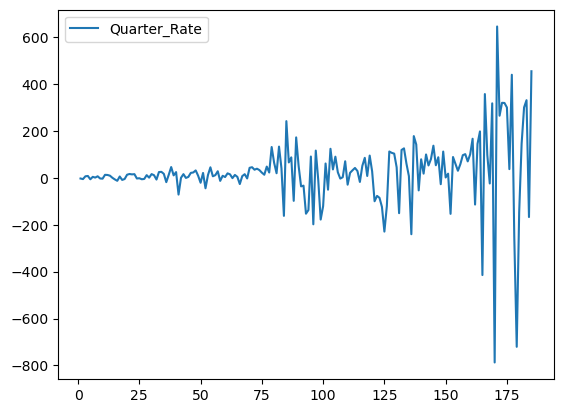

In [119]:
stock_quarter_df[['Quarter','Quarter_Rate']].plot()

# Your home work 1 assignment : get annual rate of SP500

In [106]:
# get Treasury Yield 30 Years -- ^TYX (yahoo finace ticker)
bond_rate = yf.download('^TYX', "1977-10-01", date.today()).reset_index()

[*********************100%%**********************]  1 of 1 completed


In [107]:
bond_rate.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1977-10-03,7.70,7.70,7.70,7.70,7.70,0
1,1977-10-04,7.69,7.69,7.69,7.69,7.69,0
2,1977-10-05,7.69,7.69,7.69,7.69,7.69,0
3,1977-10-06,7.72,7.72,7.72,7.72,7.72,0
4,1977-10-07,7.73,7.73,7.73,7.73,7.73,0


In [126]:
def getQuarterRate(df, rate = "Bond_Quarter"):
    #aggregate daily to quarterly, and annually rate
    df["Quarter"] = [str(i.year)+"-"+str(i.quarter) for i in df.Date]
    #df["Year"] = [str(i.year) for i in df.Date]
    
    quarterRate = {}
    for i in df.Quarter.unique():
        quarter_i = df[df.Quarter == i]
        quarterRate[i] = quarter_i.Close[quarter_i.Date == quarter_i.Date.min()].values[0] 
        
    quarterRate_df = pd.DataFrame([quarterRate]).T
    quarterRate_df.reset_index(inplace = True)
    quarterRate_df.columns = ["Quarter", rate]
    return quarterRate_df

In [127]:
bond_quarter_df = getQuarterRate(bond_rate)

In [128]:
bond_quarter_df.head()

,Quarter,Bond_Quarter
0,1977-4,7.70
1,1978-1,8.08
2,1978-2,8.32
3,1978-3,8.60
4,1978-4,8.63


# Your home work 1 assignment : get annual rate of bond

# webscraping inflation data 
* https://www.usinflationcalculator.com/inflation/historical-inflation-rates/

In [130]:
import requests
import pandas as pd

url = 'https://www.usinflationcalculator.com/inflation/historical-inflation-rates/'
html = requests.get(url).content
df_list = pd.read_html(html)

In [138]:
df_list[0].head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave
0,1914,2.0,1.0,1.0,0.0,2.1,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0
1,1915,1.0,1.0,0.0,2.0,2.0,2.0,1.0,-1.0,-1.0,1.0,1.0,2.0,1.0
2,1916,3.0,4.0,6.1,6.0,5.9,6.9,6.9,7.9,9.9,10.8,11.7,12.6,7.9
3,1917,12.5,15.4,14.3,18.9,19.6,20.4,18.5,19.3,19.8,19.5,17.4,18.1,17.4
4,1918,19.7,17.5,16.7,12.7,13.3,13.1,18.0,18.5,18.0,18.5,20.7,20.4,18.0


In [140]:
df_list[0].to_csv('inflation_data.csv', index = False)

<Axes: xlabel='Year'>

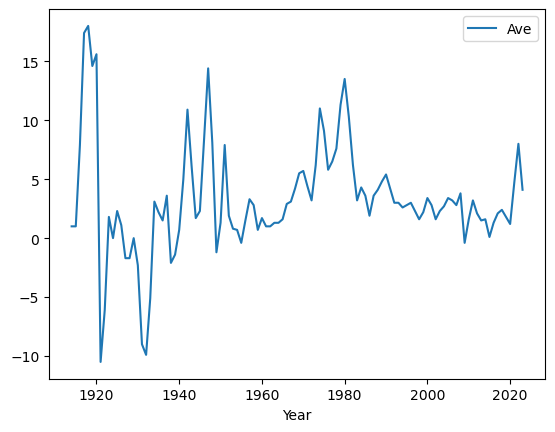

In [144]:
df_list[0][["Year", "Ave"]].plot(x= "Year", y ="Ave")

# install/load some statistical tools

In [53]:
#pip install fitter

In [5]:
#pip install scipy -U

In [191]:
#pip install statsmodels -U

In [192]:
#pip install arch

In [2]:
import statsmodels
statsmodels.__version__

'0.14.0'

# test time series statinoarity and autocorrelation

In [15]:
def adf_test(series):
    #print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    # for key,value in dftest[4].items():
    #     dfoutput['Critical Value (%s)'%key] = value
    if dftest[1] >0.05:
        print (f"{series.name} is not stationary")
    else:
        print (f"{series.name} is stationary")

In [145]:
# for i in q_r.columns[1:]:
#     adf_test(q_r_sub.loc[:,i])

In [18]:
from statsmodels.stats.stattools import durbin_watson

In [19]:
# for i in q_r_sub.columns[1:]:
#     ''' check is the DW test return a value between 1.5 and 2.5, 
#          if yes no correlation, otherwise has correlation '''    
          
#     print(i ,  durbin_watson(q_r_sub.loc[:,i]))

Stock-Total 1.6924584032578667
Dividend 0.008831889603359028
Bond-Total 1.869730439943229
Bond-Income 0.004130971725187002
Inflation 0.6043385400510163


# TEST: fit OLS model with DV = yt and IV = yt-1

In [19]:
for i in ['Dividend','Bond-Income', 'Inflation']:
    ''' use shift() to create lag(1) data '''
    q_r_sub[f"{i}_lag"] = q_r_sub[i].shift()

In [146]:
# q_r_sub.dropna(inplace = True)
# q_r_sub.head()

In [147]:
# #get correlation coefs of rates
# q_r_sub.iloc[:,[1,2,3,4,5]].corr()

# fit individual Student t-distribution

In [145]:
stats.t.fit(q_r_sub['Stock-Total']) #df, mu, sigma

(5.286461935108223, 0.03457968887136153, 0.06660030584433152)

In [259]:
stats.t.fit(q_r_sub['Stock-Total'], floc= q_r_sub['Stock-Total'].mean()) #df, mu, sigma

(6.070730536329348, 0.02894407027317073, 0.06853539039179579)

# simulate non-negative dividend 

In [146]:
div_log = np.log(q_r_sub.Dividend)
div_lag_log = np.log(q_r_sub.Dividend_lag)

In [147]:
dividend_fit = LinearRegression().fit(pd.DataFrame(div_lag_log), div_log)
print(f"intercept: {dividend_fit.intercept_}; coef_: {dividend_fit.coef_}")

intercept: -0.11631923080675044; coef_: [0.97758717]


In [148]:
dividend_error = div_log - dividend_fit.predict(pd.DataFrame(div_lag_log))

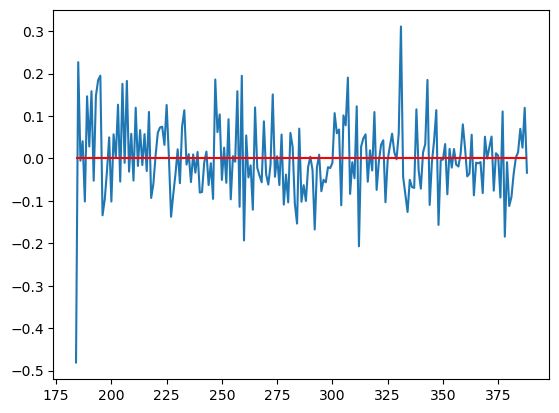

In [149]:
plt.plot(dividend_error)
plt.hlines(y = 0, xmin = dividend_error.index.min(), xmax = dividend_error.index.max(),
           color = "red")

# fit bond income distribution

In [150]:
q_r_sub.columns

Index(['Month_year', 'Stock-Total', 'Dividend', 'Bond-Total', 'Bond-Income',
       'Inflation', 'Dividend_lag', 'Bond-Income_lag', 'Inflation_lag'],
      dtype='object')

In [151]:
income_log = np.log(q_r_sub['Bond-Income'])
income_lag_log = np.log(q_r_sub['Bond-Income_lag'])

In [152]:
income_fit = LinearRegression().fit(pd.DataFrame(income_lag_log), income_log)
print(f"intercept: {income_fit.intercept_}; coef_: {income_fit.coef_}")

intercept: -0.06333900149697413; coef_: [0.98562594]


In [153]:
income_error = income_log - income_fit.predict(pd.DataFrame(income_lag_log))

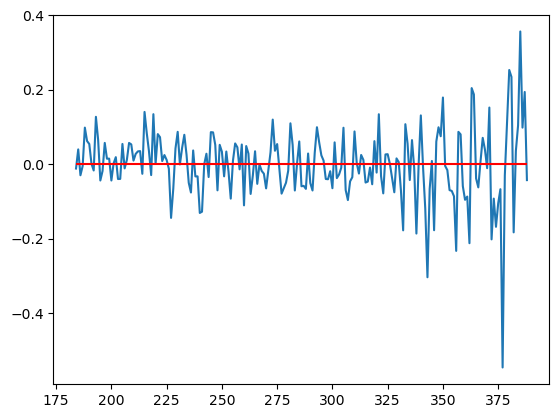

In [154]:
plt.plot(income_error)
plt.hlines(y = 0, xmin = income_error.index.min(), xmax = income_error.index.max(),
           color = "red")

# fit inflation distribution

In [155]:
q_r_sub.columns

Index(['Month_year', 'Stock-Total', 'Dividend', 'Bond-Total', 'Bond-Income',
       'Inflation', 'Dividend_lag', 'Bond-Income_lag', 'Inflation_lag'],
      dtype='object')

In [156]:
inflation_fit = LinearRegression().fit(q_r_sub[['Inflation_lag']], q_r_sub.Inflation)
print(f"intercept: {inflation_fit.intercept_}; coef_: {inflation_fit.coef_}")

intercept: 0.0058517883224974586; coef_: [0.40624012]


In [157]:
inflation_error = q_r_sub.Inflation - inflation_fit.predict(q_r_sub[['Inflation_lag']])

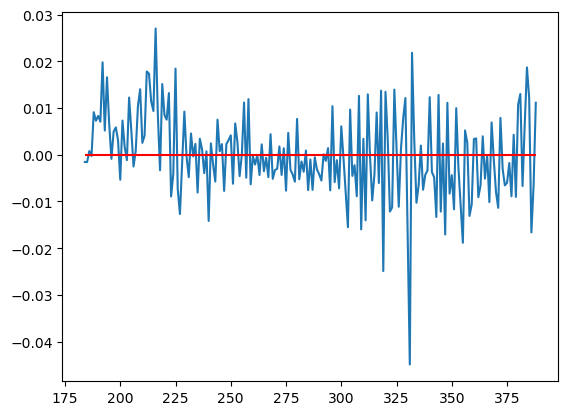

In [158]:
plt.plot(inflation_error)
plt.hlines(y = 0, xmin = inflation_error.index.min(), xmax = inflation_error.index.max(),
           color = "red")

In [159]:
pickle.dump((income_fit, dividend_fit, inflation_fit), open("fits.pkl", "wb"))

In [27]:
(income_fit, dividend_fit, inflation_fit) = pickle.load(open("fits.pkl", "rb"))

# simulate Dividend and Bond_Income errors

In [40]:
pickle.dump((income_error, dividend_error, inflation_error), open("errors.pkl", "wb"))

In [28]:
(income_error, dividend_error, inflation_error) = pickle.load(open("errors.pkl", "rb"))

In [29]:
q_r_sub.tail()

,Month_year,Stock-Total,Dividend,Bond-Total,Bond-Income,Inflation
384,2022-03-31,-0.045985,0.003618,-0.089716,0.005343,0.031212
385,2022-06-30,-0.161011,0.003917,-0.103663,0.007727,0.030633
386,2022-09-30,-0.048826,0.004049,-0.091893,0.008586,0.001677
387,2022-12-31,0.075610,0.004595,-0.002332,0.010484,-0.000037
388,2023-03-31,0.074971,0.004462,0.055545,0.010075,0.016978


# fit t-distribution of 5 rates

In [29]:
error_df = pd.concat([q_r_sub['Stock-Total'], pd.Series(income_error), 
                      pd.Series(dividend_error), pd.Series(inflation_error),
                      q_r_sub['Bond-Total']], axis = 1)                      

In [30]:
error_df.shape

(205, 5)

In [31]:
q_r_sub['Stock-Total'].mean()

0.02894407027317073

In [32]:
#fit t-distribution with the mean as location for stock and bond returns
stock_para = stats.t.fit(q_r_sub['Stock-Total'], floc= q_r_sub['Stock-Total'].mean())
income_para = stats.t.fit(income_error)
dividend_para = stats.t.fit(dividend_error)
inflation_para = stats.t.fit(inflation_error)
bond_para = stats.t.fit(q_r_sub['Bond-Total'], floc= q_r_sub['Bond-Total'].mean())

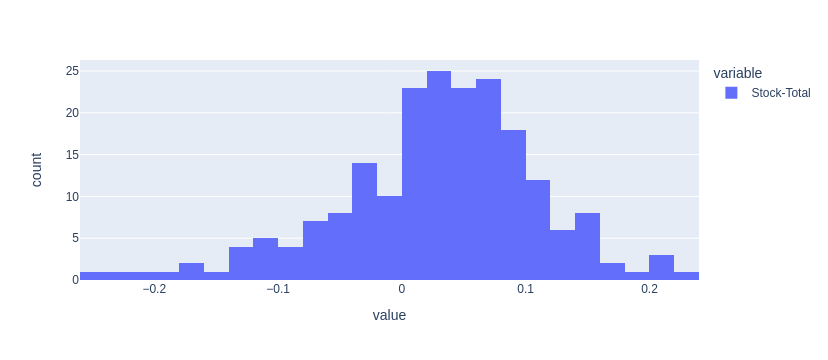

In [271]:
q_r_sub['Stock-Total'].hist(bins = 200)

In [262]:
stats.t.fit(q_r_sub['Stock-Total'], floc= q_r_sub['Stock-Total'].mean())

(6.070730536329348, 0.02894407027317073, 0.06853539039179579)

In [267]:
t_spl = stats.t.rvs(6.070730536329348, 0.02894407027317073, 0.06853539039179579, size = 10000)

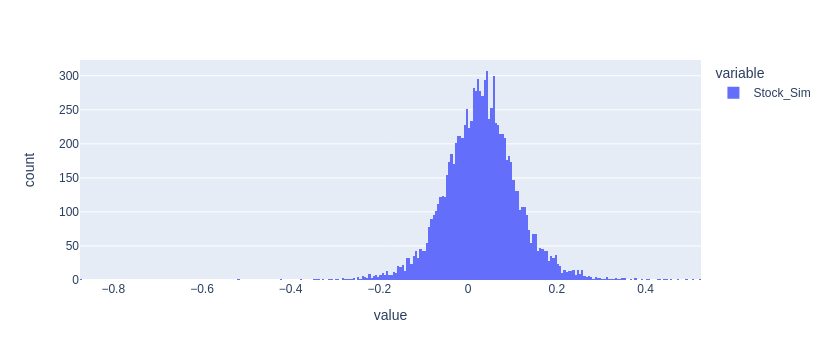

In [268]:
pd.Series(t_spl, name = "Stock_Sim").hist()

In [15]:
# for i in [stock_para, income_para, dividend_para, inflation_para, bond_para]:
#     print(i)

In [114]:
#degree of freedom for StudentTCopula()
df = np.mean([stock_para[0], income_para[0], dividend_para[0], inflation_para[0], bond_para[0]])
df

5.829194340544427

In [33]:
marginal_lst = [stats.t(6.070730536329348, 0.02894407027317073, 0.06853539039179579),
                stats.t(3.6292200056363453, 0.0014904997502419642, 0.06336038874846509),
                stats.t(6.119519041575349, -0.0022567952568445437, 0.07478635960824295),
                stats.t(9.455323049632403, -1.0307230734858667e-05, 0.008063621436368481),
                stats.t(4.961248837988938, 0.01930228812195122, 0.047629056593244394)]      

# optimized df of StudentTCopula

In [211]:
dfs = [stock_para[0], income_para[0], dividend_para[0], inflation_para[0], bond_para[0]]

In [212]:
df_min = round(min(dfs), 2); df_max = round(max(dfs), 2)
print(df_min, df_max)

3.63 9.46


In [30]:
error_df.shape

(206, 5)

In [214]:
corr_ = np.array(error_df.corr())
corr_

array([[ 1.        , -0.19203276, -0.24678987, -0.07884368, -0.0150461 ],
       [-0.19203276,  1.        ,  0.04031975,  0.21297988, -0.29162792],
       [-0.24678987,  0.04031975,  1.        , -0.23975582,  0.16883449],
       [-0.07884368,  0.21297988, -0.23975582,  1.        , -0.32884067],
       [-0.0150461 , -0.29162792,  0.16883449, -0.32884067,  1.        ]])

In [215]:
corr_abs_diff = {}
for i in tqdm(np.arange(df_min, df_max, 0.2)):
    sc_i = StudentTCopula(corr = corr_, df = i, k_dim=5)
    joint_dist = CopulaDistribution(copula=sc_i, marginals= marginal_lst) 
    sc_spl_i = joint_dist.rvs(50000, random_state = 1234)
    corr_i = np.array(pd.DataFrame(sc_spl_i).corr())
    corr_abs_diff[i] = abs(corr_[np.triu(np.ones_like(corr_)) == 0] - \
                           corr_i[np.triu(np.ones_like(corr_)) == 0]).sum()             

100%|███████████████████████████████████████████| 30/30 [00:16<00:00,  1.82it/s]


In [216]:
df_min = min(corr_abs_diff, key = corr_abs_diff.get)
df_min

6.630000000000003

In [34]:
df_min = 6.63

In [35]:
sc = StudentTCopula(corr = np.array(error_df.corr()), df = df_min, k_dim=5)

In [36]:
joint_dist = CopulaDistribution(copula=sc, marginals= marginal_lst) 

## compare correlation of simulated and LR errors 

In [37]:
def getSim(y, ar_model, error, type = "non_log"):
    '''get simulation data from the LR'''
    
 
    sim_init = y[y.index.max()]
    sim_out = ar_model.intercept_ + ar_model.coef_[0] * sim_init + error   

    if type == "log":
        sim_out = np.exp(sim_out)
        return sim_out
    else:
        return sim_out        

In [387]:
sim140['Dividend_sim'] = getSim(np.log(q_r_sub.Dividend), 
                               dividend_fit, sim140.Dividend, type = "log")

In [388]:
sim140['Income_sim'] = getSim(np.log(q_r_sub['Bond-Income']), 
                               income_fit, sim140.Income, type = "log")

In [389]:
sim140['Inflation_sim'] = getSim(q_r_sub.Inflation, 
                               inflation_fit, sim140.Inflation, type = "non_log")

In [390]:
sim140.mean(axis= 0)

Stock            0.027171
Income           0.001703
Dividend         0.003311
Inflation       -0.000116
Bond             0.011642
Dividend_sim     0.004518
Income_sim       0.010155
Inflation_sim    0.012633
dtype: float64

# test scenarios 2 and 6

In [38]:
#read quarterly RMD
rmd_quarter = pd.read_csv("rmd_quarter.csv")

In [39]:
rmd_quarter.head()

,Age,RMA
0,64.00,2.87%
1,64.25,2.87%
2,64.50,2.87%
3,64.75,2.87%
4,65.00,2.95%


In [40]:
rmd_quarter["RMD"] = [float(i.replace("%", ""))/400 for i in rmd_quarter.RMA]
rmd_quarter.head()

,Age,RMA,RMD
0,64.00,2.87%,0.007175
1,64.25,2.87%,0.007175
2,64.50,2.87%,0.007175
3,64.75,2.87%,0.007175
4,65.00,2.95%,0.007375


In [41]:
rmd_quarter['RMD1'] = rmd_quarter.RMD*1.2

In [42]:
rmd_quarter.head()

,Age,RMA,RMD,RMD1
0,64.00,2.87%,0.007175,0.00861
1,64.25,2.87%,0.007175,0.00861
2,64.50,2.87%,0.007175,0.00861
3,64.75,2.87%,0.007175,0.00861
4,65.00,2.95%,0.007375,0.00885


In [43]:
def method_2_quarterly(org_amt, rmd_quarter, start_age, end_age, stock_bond_sim_df, 
                       stock_weight, bond_weight, rmd1 = False):
    
    balance = [] 
    withdrawal = [] 
    org_left = org_amt

    rmd_sub = rmd_quarter.loc[(rmd_quarter.Age >= start_age) & (rmd_quarter.Age <= end_age)]
    rmd_sub.index = list(np.arange(start_age, end_age+0.1, 0.25))

    for i in np.arange(start_age, end_age+0.1, 0.25):
        
        if i == start_age:
            '''withdraw RMD % initial balance at the retirement moment''' 
            if rmd1 == True:
                withdrawal_ = org_left * (rmd_sub.RMD1[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = org_left * (rmd_sub.RMD[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            
            withdrawal.append(withdrawal_)
            
            org_left =  (org_left - withdrawal_)                   
            balance.append(org_left)              

        else:            
            '''for the following quarters, the left balance will grow with total bond and total stock 
            returns before next quarterly withdrawal'''            
            grow_left =  org_left * (1 + bond_weight * stock_bond_sim_df.Bond[i] \
                                   + stock_weight * stock_bond_sim_df.Stock[i])

            if rmd1 == True:
                withdrawal_ = grow_left * rmd_sub.RMD1[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                        + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = grow_left * rmd_sub.RMD[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])              
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ >= grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_)             

    return balance, withdrawal

In [45]:
def method_6_quarterly(org_amt, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate = 0.06):
    
    balance = [] 
    withdrawal = []
    org_left = org_amt

    for i in np.arange(start_age, end_age+0.1, 0.25):        
        if i == start_age:
            '''withdraw 6% initial balance at the retirement moment'''  
            withdrawal.append(org_left * withdrawal_rate)
            org_left =  org_left * (1-withdrawal_rate)  
            balance.append(org_left)

        elif i == start_age + 0.25:
            '''apply cumulated inflation rate on the 6% of the first year balance''' 

            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = stock_bond_sim_df.Inflation[i]             
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)     
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 
        else:            
            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = (1+ stock_bond_sim_df.Inflation[i]) * (1+cum_inflation) - 1
            
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)  
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 

    return balance, withdrawal

In [46]:
def sim_10K_quarterly(org_amt, withdrawal_rate, start_age, end_age, 
            output_balance_path, output_withdrawal_path, sim_out = False):
    
    global joint_dist, q_r_sub, rmd_quarter
    
    '''1) withdrawal_rate is only for method 6
       2) Two types of rmd are used only for method 2 and 3
    '''
    
    print(f'org_amt = {org_amt}; quarterly withdrawal rate = {withdrawal_rate}')
    print(f'Output pickle files are {output_balance_path} and {output_withdrawal_path}.\n')
    
    balance_2_0_1 = {}
    balance_2_0_1_1 = {}
    balance_6_0_1 = {}
    
    withdrawal_2_0_1 = {}
    withdrawal_2_0_1_1 = {}
    withdrawal_6_0_1 = {}    
    
    quarters = np.arange(start_age, end_age+0.1, 0.25)   
    
    sim_dict = {}
    for i in tqdm(range(10000)):
        
        '''simulate 10K of 141 autocorrelated quarterly data start with the last observed autocorrelaton data'''
        
        stock_bond_sim_df = pd.DataFrame(joint_dist.rvs(141, random_state = i))                
        stock_bond_sim_df.index = list(quarters)
        stock_bond_sim_df.columns = ['Stock', 'Income','Dividend','Inflation','Bond']
        stock_bond_sim_df['Income'] = getSim(np.log(q_r_sub['Bond-Income']), 
                                             income_fit, stock_bond_sim_df.Income, type = "log")
        
        stock_bond_sim_df['Dividend'] = getSim(np.log(q_r_sub.Dividend), 
                                             dividend_fit, stock_bond_sim_df.Dividend, type = "log")
        
        stock_bond_sim_df['Inflation'] = getSim(q_r_sub.Inflation, 
                                            inflation_fit, stock_bond_sim_df.Inflation, type = "non_log")
        
        sim_dict[i] = stock_bond_sim_df

#         balance_2_6_4[i], withdrawal_2_6_4[i] = method_2_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 0.4, 0.6)

#         balance_2_7_3[i], withdrawal_2_7_3[i] = method_2_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 0.3, 0.7)
        
#         balance_2_6_4_1[i], withdrawal_2_6_4_1[i] = method_2_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 0.4, 0.6, rmd1 = True)

#         balance_2_7_3_1[i], withdrawal_2_7_3_1[i] = method_2_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 0.3, 0.7, rmd1 = True)
        balance_2_0_1[i], withdrawal_2_0_1[i] = method_2_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 1, 0)

        balance_2_0_1_1[i], withdrawal_2_0_1_1[i] = method_2_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 1, 0, rmd1 = True)

        
#         balance_3_6_4[i], withdrawal_3_6_4[i] = method_3_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 0.4, 0.6)

#         balance_3_7_3[i], withdrawal_3_7_3[i] = method_3_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 0.3, 0.7)

#         balance_3_6_4_1[i], withdrawal_3_6_4_1[i] = method_3_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 0.4, 0.6, rmd1 = True)

#         balance_3_7_3_1[i], withdrawal_3_7_3_1[i] = method_3_quarterly(org_amt,rmd_quarter,start_age, end_age, stock_bond_sim_df, 0.3, 0.7, rmd1 = True)

        
#         balance_6_6_4[i], withdrawal_6_6_4[i] = method_6_quarterly(org_amt,start_age, end_age, stock_bond_sim_df, 0.4, 0.6, withdrawal_rate =withdrawal_rate)
        balance_6_0_1[i], withdrawal_6_0_1[i] = method_6_quarterly(org_amt,start_age, end_age, stock_bond_sim_df, 1, 0, withdrawal_rate =withdrawal_rate)

#         balance_6_7_3[i], withdrawal_6_7_3[i] = method_6_quarterly(org_amt,start_age, end_age, stock_bond_sim_df, 0.3, 0.7, withdrawal_rate =withdrawal_rate)

        
    pickle.dump((balance_2_0_1, balance_2_0_1_1, balance_6_0_1),                   
                open(f"{output_balance_path}", "wb")) 
   
    pickle.dump((withdrawal_2_0_1, withdrawal_2_0_1_1, withdrawal_6_0_1),
            open(f"{output_withdrawal_path}", "wb")) 
    
    if sim_out == True:
        return sim_dict

In [42]:
org_amt = 255200
withdrawal_rate = 0.06/4
bond_weight = 0
stock_weight = 1

In [45]:
#get 1 iteration outputs
sim_dict = sim_10K_quarterly(org_amt, 0.06/4, 65, 100, 
                "./balance_quarterly_6pct_stock.pkl", 
                "./withdrawal_quarterly_6pct_stock.pkl", sim_out = True)

org_amt = 255200; quarterly withdrawal rate = 0.015
Output pickle files are ./balance_quarterly_6pct_stock.pkl and ./withdrawal_quarterly_6pct_stock.pkl.



100%|█████████████████████████████████████| 10000/10000 [02:02<00:00, 81.33it/s]


In [88]:
#sim_dict[0].to_csv("rates.csv", index = False)
sim_dict[0].head()

,Stock,Income,Dividend,Inflation,Bond
65.00,0.032198,0.010136,0.004250,0.013351,0.004110
65.25,0.088223,0.011025,0.004089,0.008114,-0.004539
65.50,0.097910,0.009943,0.004677,0.011438,0.063596
65.75,-0.022595,0.010576,0.004527,0.013336,0.020161
66.00,0.135305,0.008644,0.003712,0.027028,0.035292


In [89]:
#pickle.dump(annual_ret, open("annual_ret.pkl", "wb"))
pickle.dump(sim_dict, open("sim_dict.pkl", "wb"))

# export to csv

In [53]:
def merge_df_quarterly(input_path):
    
    '''merge balance and withdrawal side-by-side by age'''
    # # Create a new directory because it does not exist
    # is_output_path = os.path.exists(output_path)
    # if not is_output_path:
    #     os.mkdir(output_path)
    
    file_lst = os.listdir(input_path)
    file_lst.sort()
    file_lst = [i for i in file_lst if i != '.ipynb_checkpoints']
    print(len(file_lst))
    #assert len(file_lst) == 72, "The input files # is more than 72."
    #assert len(file_lst) == 12, "The # of csv files is more than 12"
    
    file_len = int(len(file_lst)/2)
    
    for i in range(file_len):
        bal_i = pd.read_csv(f'{input_path}/{file_lst[i]}')
        wdrl_i = pd.read_csv(f'{input_path}/{file_lst[i+file_len]}')
    
        out_i = pd.concat([bal_i, wdrl_i], axis = 1)
        out_i.columns = ["balance" + str(i) for i in np.arange(65, 100.1, 0.25)] + \
                        ["withdrawal" + str(i) for i in np.arange(65, 100.1, 0.25)]
        
        out_i_col = out_i.columns
        #out_i = out_i[[i for sub_i in [[out_i_col[i]] + [out_i_col[i+36]] for i in range(36)] for i in sub_i]]
        out_i.to_csv(f"{input_path}/method_{file_lst[i]}", index = False)  

In [ ]:
# def export_csv_quarterly(input_bal_path, input_wdrl_path, output_csv_path):
    
#     is_output_path = os.path.exists(output_csv_path)
#     if not is_output_path:
#         os.mkdir(output_csv_path)

#     (bal_2_6_4, bal_2_7_3, bal_2_6_4_1, bal_2_7_3_1, bal_6_6_4, bal_6_7_3) \
#              = pickle.load(open(f"{input_bal_path}", "rb"))
    
#     (wdrl_2_6_4, wdrl_2_7_3, wdrl_2_6_4_1, wdrl_2_7_3_1, wdrl_6_6_4, wdrl_6_7_3) \
#              = pickle.load(open(f"{input_wdrl_path}", "rb"))
        
#     export_lst = ['bal_2_6_4', 'wdrl_2_6_4', 'bal_2_7_3', 'wdrl_2_7_3',
#                   'bal_2_6_4_1', 'wdrl_2_6_4_1', 'bal_2_7_3_1', 'wdrl_2_7_3_1',
#                   'bal_6_6_4', 'wdrl_6_6_4', 'bal_6_7_3', 'wdrl_6_7_3']
    
#     for idx, _dict in enumerate((bal_2_6_4, wdrl_2_6_4, bal_2_7_3, wdrl_2_7_3,
#                                  bal_2_6_4_1, wdrl_2_6_4_1, bal_2_7_3_1, wdrl_2_7_3_1,
#                                  bal_6_6_4, wdrl_6_6_4,bal_6_7_3, wdrl_6_7_3)):        
        
#         bal_i = pd.DataFrame.from_dict(_dict, orient = "index", columns = list(np.arange(65, 100.1, 0.25)))
#         bal_i.to_csv(f"{output_csv_path}/{export_lst[idx]}.csv", index = False)  

In [47]:
def export_csv_quarterly_stock(input_bal_path, input_wdrl_path, output_csv_path):
    
    is_output_path = os.path.exists(output_csv_path)
    if not is_output_path:
        os.mkdir(output_csv_path)

    (bal_2_0_1, bal_2_0_1_1, bal_6_0_1) \
             = pickle.load(open(f"{input_bal_path}", "rb"))
    
    (wdrl_2_0_1, wdrl_2_0_1_1, wdrl_6_0_1) \
             = pickle.load(open(f"{input_wdrl_path}", "rb"))
        
    export_lst = ['bal_2_0_1', 'wdrl_2_0_1', 
                  'bal_2_0_1_1', 'wdrl_2_0_1_1',
                  'bal_6_0_1', 'wdrl_6_0_1']
    
    for idx, _dict in enumerate((bal_2_0_1, wdrl_2_0_1,
                                 bal_2_0_1_1, wdrl_2_0_1_1,
                                 bal_6_0_1, wdrl_6_0_1)):        
        
        bal_i = pd.DataFrame.from_dict(_dict, orient = "index", columns = list(np.arange(65, 100.1, 0.25)))
        bal_i.to_csv(f"{output_csv_path}/{export_lst[idx]}.csv", index = False) 

# run 10K simulations on General settings

In [92]:
org_amt = 255200
withdrawal_rate = 0.06/4
# bond_weight = 0.6
# stock_weight = 0.4

In [93]:
# %%time

# sim_dict = sim_10K_quarterly(org_amt, rmd, 0.06/4, 65, 100, 
#                 "./balance_quarterly_6.pkl", 
#                 "./withdrawal_quarterly_6.pkl")

In [94]:
#pickle.dump(sim_dict, open("sim_dict_fixed_mean.pkl", "wb"))

In [49]:
export_csv_quarterly_stock("./balance_quarterly_6pct_stock.pkl", "./withdrawal_quarterly_6pct_stock.pkl",
                     "./outputs_quarterly_6pct_stock/")

In [54]:
merge_df_quarterly("./outputs_quarterly_6pct_stock")

6


# get annual returns from quarterly returns

In [232]:
#sim_dict = pickle.load(open("sim_dict_fixed_mean.pkl", "rb"))

In [55]:
def annualRate(df):
    
    rate = []
    for i in range(5):      
        rate_j = 1
        for j in list(df.iloc[:,i]):
            rate_j *= (1+j)
        
        rate.append(rate_j-1)
            
    return rate    

In [57]:
# annual_ret = {}
# for i in tqdm(range(len(sim_dict))):
#     sim_i = sim_dict[i]    
    
#     ret_i = {}
#     for j in range(0, len(sim_i)-4, 4):
#         ret_i[sim_i.index[j]] = annualRate(sim_i.iloc[j:(j+4)])
        
#     annual_ret[i] = ret_i

In [62]:
#pickle.dump(annual_ret, open("annual_ret.pkl", "wb"))
pickle.dump(annual_ret, open("annual_ret_fix_mean.pkl", "wb"))

In [48]:
annual_ret = pickle.load(open("annual_ret_fix_mean.pkl", "rb"))

In [51]:
annual_ret[0][65.0]

[0.2053741870852448,
 0.04233610958871159,
 0.017659028728792103,
 0.04703939605851715,
 0.08456806663585237]

# covert quarter rate into annual rates

In [248]:
annual_rates = pd.DataFrame(columns = ['Sim', 'Stock', 'Income', 'Dividend', 'Inflation', 'Bond'])
for i in tqdm(list(annual_ret.keys())):
    df_i = pd.DataFrame(annual_ret[i]).T
    df_i.columns = ['Stock', 'Income', 'Dividend', 'Inflation', 'Bond']
    df_i["Sim"] = i
    annual_rates = pd.concat([annual_rates, df_i])

100%|████████████████████████████████████| 10000/10000 [00:39<00:00, 255.31it/s]


In [249]:
print(annual_rates.shape)
annual_rates.head()

(350000, 6)


,Sim,Stock,Income,Dividend,Inflation,Bond
65.0,0,0.205374,0.042336,0.017659,0.047039,0.084568
66.0,0,0.095912,0.039214,0.016924,0.056541,0.033769
67.0,0,0.094955,0.040528,0.017710,0.047015,0.149674
68.0,0,-0.036227,0.044169,0.018353,0.040775,0.248370
69.0,0,0.328871,0.041526,0.016763,0.065348,0.054918


In [252]:
annual_rates.iloc[:, 1:].mean(axis = 0)

Stock        0.120964
Income       0.041281
Dividend     0.018093
Inflation    0.051979
Bond         0.079473
dtype: float64

In [278]:
q_r_sub[['Stock-Total','Bond-Income','Dividend','Inflation','Bond-Total']].mean(axis = 0)*4

Stock-Total    0.115776
Bond-Income    0.063152
Dividend       0.028825
Inflation      0.039293
Bond-Total     0.077209
dtype: float64

In [317]:
pickle.dump(annual_rates, open("annual_rates.pkl", "wb"))

In [30]:
annual_rates = pickle.load(open("annual_rates.pkl", "rb"))

In [318]:
annual_rates.to_csv("annual_rates.csv", index = False)

In [31]:
def method_2_annual(org_amt, rmd_annual, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, rmd1 = False):
    
    balance = [] 
    withdrawal = [] 
    org_left = org_amt

    rmd_sub = rmd_annual.loc[(rmd_annual.Age >= start_age) & (rmd_annual.Age <= end_age)]
    rmd_sub.index = list(range(start_age, end_age+1))

    for i in range(start_age, end_age+1):
        
        if i == start_age:
            '''withdraw RMD % initial balance at the retirement moment''' 
            if rmd1 == True:
                withdrawal_ = org_left * (rmd_sub.RMD1[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = org_left * (rmd_sub.RMD[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
                
            withdrawal.append(withdrawal_)
            
            org_left =  (org_left - withdrawal_)                   
            balance.append(org_left)              

        else:            
            '''for the following years, the left balance will grow with total bond and total stock 
            returns before withdrawal next year'''            
            grow_left =  org_left * (1 + bond_weight * stock_bond_sim_df.Bond[i] \
                                   + stock_weight * stock_bond_sim_df.Stock[i])

            if rmd1 == True:
                withdrawal_ = grow_left * rmd_sub.RMD1[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])  
            else:
                withdrawal_ = grow_left * rmd_sub.RMD[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])  
            
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_)             

    return balance, withdrawal

In [32]:
def method_3_annual(org_amt, rmd_annual, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate = None):
    
    balance = [] 
    withdrawal = [] 
    org_left = org_amt

    rmd_sub = rmd.loc[(rmd.Age >= start_age) & (rmd.Age <= end_age)]
    rmd_sub.index = list(range(start_age, end_age+1))

    for i in range(start_age, end_age+1):
        if i == start_age:
            '''withdraw RMD % initial balance plus dividend and bond income of the quarter
            at the retirement moment''' 
            withdrawal_ = org_left * (rmd_sub.RMD[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            
            withdrawal.append(withdrawal_)
            
            org_left =  (org_left - withdrawal_)                   
            balance.append(org_left)              
            
        elif i == start_age+1:  
            '''after the 1st quarter, the left balance will grow with total bond and total stock 
            returns, and withdrawal comes from % of RMD, cumulated inflation of growth balance plus
            dividend and bond income of carry-over balance'''            
            grow_left =  org_left * (1 + bond_weight * stock_bond_sim_df.Bond[i] \
                                   + stock_weight * stock_bond_sim_df.Stock[i])

            cum_inflation = stock_bond_sim_df.Inflation[i]
            withdrawal_ = grow_left * rmd_sub.RMD[i] * (1 + cum_inflation) \
                                    + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                            + bond_weight * stock_bond_sim_df.Income[i])
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ >= grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:
                org_left =  (org_left - withdrawal_)                                                    
                balance.append(org_left)
                withdrawal.append(withdrawal_)      
                
        else:
            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))
            
            cum_inflation = (1+ stock_bond_sim_df.Inflation[i]) * (1+cum_inflation) - 1
            
            withdrawal_ =  (1 + cum_inflation) * (grow_left * rmd_sub.RMD[i]) \
                              + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                         + bond_weight * stock_bond_sim_df.Income[i])
                                                  
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_)  
        
    return balance, withdrawal

In [33]:
def method_6_annual(org_amt, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate = 0.06):
    
    '''with X% annual withdrawal of previous year amount plus adjustement of inflation and investment growth'''  
    #global rmd
    
    balance = [] 
    withdrawal = []
    org_left = org_amt

    # rmd_sub = rmd.loc[(rmd.Age >= start_age) & (rmd.Age <= end_age)]
    # rmd_sub.index = list(range(start_age, end_age+1))

    for i in range(start_age, end_age+1):        
        if i == start_age:
            '''withdraw 6% initial balance at the retirement moment'''  
            withdrawal.append(org_left * withdrawal_rate)
            org_left =  org_left * (1-withdrawal_rate)  
            balance.append(org_left)

        elif i == start_age + 1:
            '''apply cumulated inflation rate on the 6% of the first year balance''' 

            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = stock_bond_sim_df.Inflation[i]             
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)               
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 
        else:            
            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = (1+ stock_bond_sim_df.Inflation[i]) * (1+cum_inflation) - 1
            
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)  
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 

    return balance, withdrawal

In [55]:
i = 1
stock_bond_sim_df = pd.DataFrame(annual_ret[i]).T
stock_bond_sim_df.columns = ['Stock', 'Income', 'Dividend', 'Inflation', 'Bond']
stock_bond_sim_df.index = [int(i) for i in stock_bond_sim_df.index]

In [56]:
stock_bond_sim_df.Stock.mean()

0.06761250790573729

In [34]:
def sim_10K_annual(annual_ret, org_amt, withdrawal_rate, start_age, end_age, 
                   output_balance_path, output_withdrawal_path):
    
    global rmd_annual
    
#     is_output_balance = os.path.exists(output_balance_path)
#     if not is_output_balance:
#         os.mkdir(output_balance_path)
        
#     is_output_withdrawal = os.path.exists(output_withdrawal_path)
#     if not is_output_withdrawal:
#         os.mkdir(output_withdrawal_path)        
    
    print(f'org_amt = {org_amt}; withdrawal_rate = {withdrawal_rate}')
    print(f'Output pickle files is {output_balance_path} and {output_withdrawal_path}.')
    
    method_2_0_1 = {}
    method_2_0_1_1 = {}
    method_6_0_1 = {}
    
   
    withdrawal_2_0_1 = {}
    withdrawal_2_0_1_1 = {}
    withdrawal_6_0_1 = {}
    
   
    for i in tqdm(range(10000)):
        
        #stock_bond_sim_df = best_fit_df.sample((end_age-start_age +1), random_state = i)
        #stock_bond_sim_df.index = list(range(start_age, end_age+1))
        stock_bond_sim_df = pd.DataFrame(annual_ret[i]).T
        stock_bond_sim_df.columns = ['Stock', 'Income', 'Dividend', 'Inflation', 'Bond']
        stock_bond_sim_df.index = [int(i) for i in stock_bond_sim_df.index]

#         method_1_6_4[i], withdrawal_1_6_4[i] = method_1(org_amt,start_age, end_age, stock_bond_sim_df, 0.4, 0.6)

#         method_1_7_3[i], withdrawal_1_7_3[i] = method_1(org_amt,start_age, end_age, stock_bond_sim_df, 0.3, 0.7)

        method_2_0_1[i], withdrawal_2_0_1[i]= method_2_annual(org_amt, rmd_annual, start_age, end_age, stock_bond_sim_df, 1, 0)

        #method_2_7_3[i], withdrawal_2_7_3[i] = method_2_annual(org_amt,rmd_annual, start_age, end_age, stock_bond_sim_df, 0.3, 0.7)

        method_2_0_1_1[i], withdrawal_2_0_1_1[i] = method_2_annual(org_amt,rmd_annual, start_age, end_age, stock_bond_sim_df, 1, 0, rmd1 = True)

        method_6_0_1[i], withdrawal_6_0_1[i] = method_6_annual(org_amt,start_age, end_age, stock_bond_sim_df, 1, 0, withdrawal_rate = withdrawal_rate)

        #method_6_7_3[i], withdrawal_6_7_3[i] = method_6_annual(org_amt,start_age, end_age, stock_bond_sim_df, 0.3, 0.7, withdrawal_rate = withdrawal_rate)
    
    pickle.dump((method_2_0_1, method_2_0_1_1, method_6_0_1),   
                open(f"{output_balance_path}", "wb")) 
    # pickle.dump((method_2_6_4, method_2_7_3, 
    #              method_2_6_4_1, method_2_7_3_1, 
    #              method_6_6_4, method_6_7_3),   
    #             open(f"{output_balance_path}", "wb"))
        
    pickle.dump((withdrawal_2_0_1, withdrawal_2_0_1_1, withdrawal_6_0_1),
                 open(f"{output_withdrawal_path}", "wb")) 
    
    # pickle.dump((withdrawal_2_6_4, withdrawal_2_7_3, 
    #              withdrawal_2_6_4_1, withdrawal_2_7_3_1, 
    #              withdrawal_6_6_4, withdrawal_6_7_3) ,
    #              open(f"{output_withdrawal_path}", "wb")) 

In [35]:
org_amt = 255200
withdrawal_rate = 0.06
bond_weight = 0
stock_weight = 1

In [58]:
rmd_annual = pd.read_csv("RMD.csv") #annual RMD

In [59]:
rmd_annual.head()

,Age,RMD
0,62,0.0272
1,63,0.0279
2,64,0.0287
3,65,0.0295
4,66,0.0303


In [60]:
rmd_annual['RMD1'] = rmd_annual.RMD*1.2

In [61]:
rmd_annual.head()

,Age,RMD,RMD1
0,62,0.0272,0.03264
1,63,0.0279,0.03348
2,64,0.0287,0.03444
3,65,0.0295,0.03540
4,66,0.0303,0.03636


In [39]:
%%time

sim_10K_annual(annual_ret, 255200, 0.06, 65, 99, "./quarter2annual_balance_6pct_stock.pkl", 
               "./quarter2annual_withdrawal_6pct_stock.pkl")

org_amt = 255200; withdrawal_rate = 0.06
Output pickle files is ./quarter2annual_balance_6pct_stock.pkl and ./quarter2annual_withdrawal_6pct_stock.pkl.


100%|████████████████████████████████████| 10000/10000 [00:32<00:00, 308.80it/s]


CPU times: user 35.7 s, sys: 507 ms, total: 36.2 s
Wall time: 36.1 s


In [40]:
def export_csv_annual_stock(input_bal_path, input_wdrl_path, output_csv_path):
    
    is_output_path = os.path.exists(output_csv_path)
    if not is_output_path:
        os.mkdir(output_csv_path)

    (bal_2_0_1, bal_2_0_1_1, bal_6_0_1) \
             = pickle.load(open(f"{input_bal_path}", "rb"))
    
    (wdrl_2_0_1, wdrl_2_0_1_1, wdrl_6_0_1) \
             = pickle.load(open(f"{input_wdrl_path}", "rb"))
        
    export_lst = ['bal_2_0_1', 'wdrl_2_0_1', 'bal_2_0_1_1', 'wdrl_2_0_1_1', 'bal_6_0_1', 'wdrl_6_0_1']
    
    for idx, _dict in enumerate((bal_2_0_1, wdrl_2_0_1, bal_2_0_1_1, 
                                 wdrl_2_0_1_1, bal_6_0_1, wdrl_6_0_1)):        
        
        bal_i = pd.DataFrame.from_dict(_dict, orient = "index", columns = list(range(65, 100)))
        bal_i.to_csv(f"{output_csv_path}/{export_lst[idx]}.csv", index = False)  

In [41]:
export_csv_annual_stock("./quarter2annual_balance_6pct_stock.pkl", 
                  "./quarter2annual_withdrawal_6pct_stock.pkl",
                  "./outputs_annual_6pct_stock/")

In [42]:
def merge_df_annual(input_path):
    
    '''merge balance and withdrawal side-by-side by age'''
    # # Create a new directory because it does not exist
    # is_output_path = os.path.exists(output_path)
    # if not is_output_path:
    #     os.mkdir(output_path)
    
    file_lst = os.listdir(input_path)
    file_lst.sort()
    file_lst = [i for i in file_lst if ".csv" in i]
    #print(len(file_lst))
    #assert len(file_lst) == 72, "The input files # is more than 72."
    
    file_len = int(len(file_lst)/2)
    
    for i in range(file_len):
        bal_i = pd.read_csv(f'{input_path}/{file_lst[i]}')
        wdrl_i = pd.read_csv(f'{input_path}/{file_lst[i+file_len]}')
    
        out_i = pd.concat([bal_i, wdrl_i], axis = 1)
        out_i.columns = ["balance" + str(i) for i in range(65, 100)] + \
                        ["withdrawal" + str(i) for i in range(65, 100)]
        
        out_i_col = out_i.columns
        #out_i = out_i[[i for sub_i in [[out_i_col[i]] + [out_i_col[i+36]] for i in range(36)] for i in sub_i]]
        out_i.to_csv(f"{input_path}/method_{file_lst[i]}", index = False)   

In [43]:
merge_df_annual("./outputs_annual_6pct_stock/")

In [225]:
%%time

sim_10K_annual(annual_ret, 255200, 0.06, 65, 99, "./quarter2annual_balance_6pct.pkl", 
               "./quarter2annual_withdrawal_6pct.pkl")

org_amt = 255200; withdrawal_rate = 0.06
Output pickle files is ./quarter2annual_balance_6pct.pkl and ./quarter2annual_withdrawal_6pct.pkl.


100%|████████████████████████████████████| 10000/10000 [00:59<00:00, 166.67it/s]


CPU times: user 1min 7s, sys: 929 ms, total: 1min 8s
Wall time: 1min 8s


In [226]:
export_csv_annual("./quarter2annual_balance_6pct.pkl", 
                  "./quarter2annual_withdrawal_6pct.pkl",
                  "./outputs_annual_6pct/")

In [227]:
merge_df_annual("./outputs_annual_6pct/")

In [63]:
bal_201 = pd.read_csv("./outputs_annual_6pct_stock/method_bal_2_0_1.csv")

In [66]:
bal_201.shape

(10000, 70)

In [67]:
bal_201.head()

,balance65,balance66,balance67,balance68,balance69,balance70,balance71,balance72,balance73,balance74,...,withdrawal90,withdrawal91,withdrawal92,withdrawal93,withdrawal94,withdrawal95,withdrawal96,withdrawal97,withdrawal98,withdrawal99
0,243165.015868,254297.572960,265225.633118,242518.834114,307511.351006,377176.171427,514097.508107,541992.112153,541081.469337,656144.980845,...,321857.395772,320586.236686,344188.601982,314368.885126,300343.521174,366094.233324,450542.995751,589076.619671,592167.449314,532869.128907
1,243044.356178,182696.481021,159738.834051,128022.544945,122562.771932,134146.175281,148935.675049,140619.503430,133956.962274,142114.992423,...,25055.496075,30831.751311,32285.673040,39128.629252,27197.319172,25898.236342,24122.582828,23760.922956,24715.460946,23043.274423
2,243113.841516,221643.104433,243644.836136,305210.553344,288070.116945,427387.948460,336281.856443,350867.504099,403909.885115,467764.633438,...,226497.663604,267060.018227,268324.997376,275061.858390,237593.821837,248243.675499,282647.722576,371282.503914,524428.601689,524198.407972
3,242760.334382,258081.556620,325693.935850,361010.224816,416807.150956,408386.692132,564795.369428,535873.914263,494279.313822,482516.085914,...,28781.444286,34415.176349,39994.199572,48325.526455,44102.667723,43926.293727,42539.167258,36095.339170,27505.744211,29568.549632
4,243095.006672,179247.733302,169018.963676,189573.737091,196836.137924,207870.757722,260943.354324,313150.017920,338270.640927,309170.147036,...,40761.589314,49987.327426,53245.876409,46151.183158,50608.427067,56968.714704,58373.864306,53982.725308,56508.326967,74102.409294


In [70]:
bal_201[bal_201.balance66 == 0]

,balance65,balance66,balance67,balance68,balance69,balance70,balance71,balance72,balance73,balance74,...,withdrawal90,withdrawal91,withdrawal92,withdrawal93,withdrawal94,withdrawal95,withdrawal96,withdrawal97,withdrawal98,withdrawal99
5365,243174.912249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9907,242830.338319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
def getRate(i):
    global annual_ret
    stock_bond_sim_df = pd.DataFrame(annual_ret[i]).T
    stock_bond_sim_df.columns = ['Stock', 'Income', 'Dividend', 'Inflation', 'Bond']
    stock_bond_sim_df.index = [int(i) for i in stock_bond_sim_df.index]
    return stock_bond_sim_df

In [73]:
iter_5365 = getRate(5365)
iter_9907 = getRate(9907)

In [75]:
iter_9907.head()

,Stock,Income,Dividend,Inflation,Bond
65,-0.039418,0.041737,0.018970,0.051773,0.223410
66,-1.159508,0.044044,0.019120,0.049565,0.215246
67,0.263439,0.039313,0.016794,0.049801,-0.015855
68,0.191191,0.042017,0.018794,0.050874,0.087449
69,0.100889,0.041931,0.018487,0.027714,0.345842


In [74]:
iter_5365.to_csv("iter_5365.csv")
iter_9907.to_csv("iter_9907.csv")

In [223]:
for i in file_lst:
    method_i = i.split("method_bal_")[1].split(".")[0]
    
    csv_i = pd.read_csv(f"./output_all/{i}")
    bal_i = csv_i.iloc[:, range(0, 141, 4)] #create quarterly balance columns
    bal_i.columns = [i.replace(".0", "") for i in bal_i.columns] 
    bal_i.to_csv(f"./output_all/bal_{method_i}.csv", index = False)
    
    wdr_i = csv_i.iloc[:, 141:]
    
    wdr_j = pd.DataFrame()
    for j in range(0, 141-3, 4):
        '''create quarterly withdrawal columns'''
        wdr_j= pd.concat([wdr_j, wdr_i.iloc[:, [j, j+1, j+2, j+3]].sum(axis = 1)], axis = 1)   
        
    wdr_j.columns = ["withdrawal" + str(i) for i in np.arange(65, 100)]   
    wdr_j.to_csv(f"./output_all/wdr_{method_i}.csv", index = False)

In [224]:
bal_2 = pd.read_csv("./output_all/method_bal_2_6_4.csv")

In [225]:
bal_2.head()

,balance65.0,balance65.25,balance65.5,balance65.75,balance66.0,balance66.25,balance66.5,balance66.75,balance67.0,balance67.25,...,withdrawal97.75,withdrawal98.0,withdrawal98.25,withdrawal98.5,withdrawal98.75,withdrawal99.0,withdrawal99.25,withdrawal99.5,withdrawal99.75,withdrawal100.0
0,251331.988273,255445.579654,270954.805964,267645.335214,283671.943472,281302.849446,273983.727464,267290.264513,277581.040632,270490.755609,...,31917.246992,34344.515285,33672.125589,32390.025870,29886.122326,30373.201801,30416.544473,28490.026287,26987.678080,27741.279795
1,251265.095342,245437.480814,229692.079768,230000.768569,228552.912979,199362.937932,202489.014123,199156.743227,208537.387209,212613.191064,...,5449.555789,5727.720486,5757.229726,5512.392038,5455.781962,5418.734010,5270.098984,5020.100798,4956.830990,4513.401655
2,251375.795700,260161.442198,287145.003892,335991.032963,344992.644888,322291.360221,321846.083831,343368.950106,343606.634496,347852.758677,...,19714.450421,20888.916372,22662.916168,23589.675407,22991.387696,24003.121892,22857.203221,22797.410323,23231.018939,23848.314069
3,251383.295354,244690.881309,258600.526471,249687.993909,250762.752918,276487.902785,264967.923200,268144.645530,259774.989370,245224.568201,...,6434.661383,6242.624641,6116.851735,6089.095980,5612.476136,5814.379687,5564.835925,5350.296434,5138.711456,5458.245682
4,251269.183589,251257.176949,255810.127266,255110.086128,263272.996114,241609.810313,226860.745077,215401.914701,208344.397800,185188.217455,...,3575.944502,3588.977439,3495.975378,3265.077386,3292.441985,3485.188158,3441.593810,3359.080243,3493.717544,3736.163763


# get annual withdrawal rate

In [149]:
bal_2_ = bal_2.iloc[:, :141]
bal_2_.shape

(10000, 141)

In [171]:
bal_2_.head()

,balance65.0,balance65.25,balance65.5,balance65.75,balance66.0,balance66.25,balance66.5,balance66.75,balance67.0,balance67.25,...,balance97.75,balance98.0,balance98.25,balance98.5,balance98.75,balance99.0,balance99.25,balance99.5,balance99.75,balance100.0
0,251168.182813,245342.683021,223436.340922,191387.062092,205525.561508,223199.065588,223486.869933,231445.064995,229979.921839,220820.563771,...,176286.859098,184853.158605,186065.747756,181749.026375,181354.294871,187507.418555,179408.304473,156237.423652,153372.146989,144298.304523
1,251419.930662,241183.380107,214135.048566,221489.182663,242353.664325,252615.513314,257535.797348,271448.704502,280743.338375,286102.470828,...,160893.172187,158711.110714,170650.337787,162532.790141,160847.087362,157260.309886,159336.219576,157729.813397,168019.061744,168110.060512
2,251150.211857,247806.184656,253270.623832,258469.182150,236483.610405,253146.379979,228185.931623,226216.687881,223273.159836,223157.770690,...,191657.477576,182295.241671,181247.874802,181314.094123,177638.287041,177104.111271,181365.111804,171462.629992,169604.044988,166846.434985
3,251351.900060,267928.421310,270375.423996,284675.034906,288548.654264,299765.258856,299808.677727,298301.942304,336729.088440,344790.047842,...,65424.350723,70576.066069,65039.232532,63406.745128,63457.268985,62525.920049,62662.895724,60306.924325,62400.776828,62173.551722
4,251579.193621,263401.135836,255021.755943,261270.751212,274625.680326,274558.938634,275546.462501,286847.496769,305712.364032,302410.416094,...,146619.085432,152037.087151,144333.192960,130395.890977,132177.312930,133460.198477,133820.402650,137370.631572,136077.437952,140657.894255


In [150]:
bal_init = 255200

In [162]:
def getAnnualRate(bal_df):
    global bal_init
    
    annual_bal_rate = 1 - (bal_init - bal_df.iloc[:, 0])/bal_init
    for i in range(1, len(bal_df.columns)):
        annual_bal_rate *= 1- (bal_df.iloc[:, i] - bal_df.iloc[:, i-1])/bal_df.iloc[:, i-1]
    
    return annual_bal_rate

In [169]:
annual_col = bal_2_.columns[list(range(0, 141, 4))]
annual_rate = pd.DataFrame(columns = annual_col)
for i in range(0, 141, 4):
    df_i = bal_2_.iloc[:, i:(i+4)]
    annual_rate.loc[:,bal_2_.columns[i]] = getAnnualRate(df_i)

In [170]:
annual_rate.head()

,balance65.0,balance66.0,balance67.0,balance68.0,balance69.0,balance70.0,balance71.0,balance72.0,balance73.0,balance74.0,...,balance91.0,balance92.0,balance93.0,balance94.0,balance95.0,balance96.0,balance97.0,balance98.0,balance99.0,balance100.0
0,1.254289,0.70897,0.979462,0.832965,0.836523,0.793958,0.704383,0.755606,1.181826,0.963799,...,0.791941,1.021809,0.9945,1.082144,1.238678,1.178694,0.857373,0.737888,0.881348,0.565432
1,1.101124,0.843563,0.967384,1.200407,1.180691,1.409491,1.180196,1.439879,1.752109,1.624392,...,1.706391,1.0211,1.087127,1.401131,1.185238,0.768376,0.894867,0.608731,0.574152,0.658738
2,0.955227,0.954465,0.852296,0.906274,0.856493,0.756629,0.794018,1.031198,1.059416,0.864291,...,0.697237,0.830162,0.815784,0.703994,0.902674,0.742615,0.736972,0.732724,0.722007,0.653787
3,0.863353,1.092028,1.281511,1.390734,1.300676,1.29646,1.051099,1.150717,1.192984,1.320874,...,0.459033,0.519171,0.477153,0.495616,0.370011,0.379361,0.307079,0.30549,0.244855,0.243627
4,0.945622,1.028522,1.245773,1.087455,1.570306,0.983037,1.128786,1.613606,1.163297,1.179347,...,0.868106,0.850998,0.644543,0.683713,0.720013,0.53187,0.566354,0.67701,0.512495,0.551167


In [97]:
bal_2_ = bal_2.iloc[:, range(0, 141, 4)]

In [103]:
bal_2_.shape

(10000, 36)

In [99]:
bal_2_.columns = [i.replace(".0", "") for i in bal_2_.columns]

In [100]:
bal_2_.head()

,balance65,balance66,balance67,balance68,balance69,balance70,balance71,balance72,balance73,balance74,...,balance91,balance92,balance93,balance94,balance95,balance96,balance97,balance98,balance99,balance100
0,251168.182813,205525.561508,229979.921839,213847.184769,210312.475491,201812.894003,207716.614296,225807.159986,269094.338154,257762.671646,...,237028.263537,263119.327644,266910.841153,291289.397780,286499.164477,247262.566319,196867.344510,184853.158605,187507.418555,144298.304523
1,251419.930662,242353.664325,280743.338375,331094.219841,328861.066056,345258.627184,333944.381859,406446.089105,444237.592107,431953.485023,...,394100.161055,275472.191925,288292.915129,303749.288259,248327.678000,206018.203098,193376.621503,158711.110714,157260.309886,168110.060512
2,251150.211857,236483.610405,223273.159836,233690.175675,219363.686531,213055.122368,231461.924394,252513.019752,245011.184901,231852.397178,...,189979.389081,211664.525372,211620.107578,198563.729561,206082.129113,187849.799713,190445.970379,182295.241671,177104.111271,166846.434985
3,251351.900060,288548.654264,336729.088440,337566.546222,319685.317253,311794.784579,291119.621054,311386.014251,337186.643018,367529.843539,...,126265.960899,129953.179649,123211.911666,110453.676831,91639.472194,83932.821916,71705.832274,70576.066069,62525.920049,62173.551722
4,251579.193621,274625.680326,305712.364032,287666.301748,339361.329148,261950.247101,309921.167349,345367.585358,282040.350798,282497.548499,...,217653.837687,193928.619427,172461.340642,171954.865599,164853.530098,145309.038439,145586.166899,152037.087151,133460.198477,140657.894255


In [102]:
bal_2_.balance100.mean()

193751.21415586935

In [287]:
bal_2_.to_csv("bal_2.csv", index = False)

In [289]:
bal_2_.shape

(10000, 36)

In [266]:
wdr_2 = bal_2.iloc[:, 141:]

In [267]:
wdr_2.head()

,withdrawal65.0,withdrawal65.25,withdrawal65.5,withdrawal65.75,withdrawal66.0,withdrawal66.25,withdrawal66.5,withdrawal66.75,withdrawal67.0,withdrawal67.25,...,withdrawal97.75,withdrawal98.0,withdrawal98.25,withdrawal98.5,withdrawal98.75,withdrawal99.0,withdrawal99.25,withdrawal99.5,withdrawal99.75,withdrawal100.0
0,3752.028301,3887.313187,4092.055618,4077.747513,4028.482353,4266.440984,4423.253428,4410.886292,4287.260808,4196.318727,...,10750.983920,11820.496046,11278.602161,10909.735348,11407.113665,11521.886951,11963.859878,12128.030877,11833.122990,11933.211172
1,3766.498831,3664.023794,3850.674504,3734.807629,4049.005845,4103.309991,3611.322476,3415.451686,3437.718570,3388.990433,...,11433.471361,11975.989802,11784.655613,11674.818110,11535.305006,12734.251617,13839.894503,13788.465972,13866.379481,14324.572320
2,3717.663196,3892.269376,4010.156062,3840.611346,3946.234101,4322.756826,4625.377235,4703.191715,4770.252092,4620.127585,...,7831.127220,7856.384910,7996.547055,7316.060457,6968.562542,7574.064302,7464.282112,7243.876112,6747.417794,6771.019618
3,3823.616262,4023.477647,3947.866827,3933.273124,4139.212563,3914.753537,3748.316879,3556.040475,3964.968396,3923.882064,...,6922.007602,6948.863175,6725.728325,6325.351456,6218.249058,6685.576284,6833.444581,6571.222605,6348.130207,6809.353182
4,3630.728418,3773.576910,3696.036437,3788.240351,3571.256519,3794.673814,3752.615997,3829.100552,3830.760460,3998.410280,...,3749.190689,3896.486883,3885.421840,3814.748276,3793.533304,3909.721084,3845.867443,3742.755741,3659.123182,3744.474059


In [273]:
wdr_yr = pd.DataFrame()
for i in range(0, 141-3, 4):
    wdr_yr = pd.concat([wdr_yr, wdr_2.iloc[:, [i, i+1, i+2, i+3]].sum(axis = 1)], axis = 1)    

In [278]:
wdr_yr.shape

(10000, 35)

In [281]:
wdr_yr.columns = ["withdrawal" + str(i) for i in np.arange(65, 100)]

In [282]:
wdr_yr.head()

,withdrawal65,withdrawal66,withdrawal67,withdrawal68,withdrawal69,withdrawal70,withdrawal71,withdrawal72,withdrawal73,withdrawal74,...,withdrawal90,withdrawal91,withdrawal92,withdrawal93,withdrawal94,withdrawal95,withdrawal96,withdrawal97,withdrawal98,withdrawal99
0,15809.144619,17129.063056,17298.882977,18673.854347,16343.687292,14013.028693,15724.985840,14787.002312,14638.698506,15126.980660,...,39828.005273,37699.708379,41328.230512,40144.797078,43764.283525,48292.987742,44542.482007,42487.837167,45415.947221,47446.900696
1,15016.004757,15179.089998,13813.479429,14363.273816,14205.506391,13566.397462,14061.148078,15737.741217,15747.916048,19123.656844,...,51544.522016,51997.562515,56405.040067,53150.297466,51161.382648,53178.914425,49803.840804,47702.418214,46970.768532,54228.991574
2,15460.699980,17597.559878,20164.091527,22576.648061,27372.910635,25918.697467,29904.490638,32821.553547,34039.080570,35456.166373,...,33777.718434,32385.893438,29571.538595,33191.591800,34876.725394,36620.904450,34521.946881,32029.285703,30137.554964,29029.640320
3,15728.233859,15358.323454,16455.445211,20815.332967,21343.133876,21549.641801,23409.454475,23938.666345,23410.184328,22248.471851,...,25405.269884,25607.436016,26444.402761,27843.951825,30204.982670,29620.691719,30731.117209,29319.983268,26218.192015,26438.373678
4,14888.582115,14947.646883,15663.293495,16051.552997,16921.290649,15831.671109,14736.325508,15088.201478,16022.574288,18240.829709,...,16943.589994,17990.682713,18318.995124,18594.833331,18412.608260,17064.624634,18416.146588,16533.055879,15390.190302,15157.467450


In [288]:
wdr_yr.shape

(10000, 35)

In [290]:
wdr_yr.to_csv("wdr_yr.csv", index = False)

# Mississippi

In [ ]:
# mississippi test
org_amt = 617661
withdrawal_rate = 0.0725

In [ ]:
print(f'org_amt = {org_amt}; withdrawal_rate = {withdrawal_rate}')

In [ ]:
%%time

sim_10K(best_sim, 617661, 0.0725, 65, 100, 
        "./new_best_5_mississippi_balance.pkl", "./new_best_5_mississippi_withdrawal.pkl")

In [ ]:
export_csv("./new_best_5_mississippi_balance.pkl", "./new_best_5_mississippi_withdrawal.pkl", 
           "./outputs/best_5_mississippi/")

In [ ]:
merge_df("./outputs/best_5_mississippi",)

# New Hampshire

In [ ]:
org_amt = 946850
withdrawal_rate = 0.0591

In [ ]:
print(f'org_amt = {org_amt}; withdrawal_rate = {withdrawal_rate}')

In [ ]:
%%time

sim_10K(best_sim, 946850, 0.0591, 65, 100, "./new_best_5_newhampshire_balance.pkl", 
        "./new_best_5_newhampshire_withdrawal.pkl")

In [ ]:
export_csv("./new_best_5_newhampshire_balance.pkl", "./new_best_5_newhampshire_withdrawal.pkl", 
           "./outputs/best_5_newhampshire")

In [ ]:
merge_df("./outputs/best_5_newhampshire")

# concat median by age and plot

In [44]:
try:
    import plotly
except:
    !pip install -U plotly

In [45]:
try:
    import kaleido
except:
    !pip install kaleido

In [46]:
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.default_format = "svg"

In [49]:
def prep_plot(pkl, col_name = 'method'):
    
    (method_2_0_1, method_2_0_1_1, method_6_0_1) = pickle.load(open(pkl, "rb"))   


    method_median = pd.Series(list(range(65, 101)), name = "Age")
    method_median.index = [int(j) for j in list(range(65, 101))]
    for i in tqdm((method_2_0_1, method_2_0_1_1, method_6_0_1)):
        df_i = pd.DataFrame.from_dict(i, orient = "index", columns = list(range(65, 100)))
    
        method_median = pd.concat([method_median, df_i.median(axis =0)], axis = 1)
    
    method_median.columns = ['Age',f'{col_name}_2_0_1', f'{col_name}_2_0_1_1',                               
                             f'{col_name}_6_0_1']
    
    return method_median

In [52]:
withdrwal_median_6_stock = prep_plot('quarter2annual_withdrawal_6pct_stock.pkl', col_name = 'Withdrawal')    

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 25.23it/s]


In [53]:
withdrwal_median_6_stock.head()

,Age,Withdrawal_2_0_1,Withdrawal_2_0_1_1,Withdrawal_6_0_1
65,65,12142.606789,13648.286789,15312.000000
66,66,12598.939358,14146.875081,16833.386481
67,67,13618.505388,15221.701902,18363.756231
68,68,14669.165719,16293.134411,20013.192954
69,69,15703.838438,17348.902814,21555.780449


In [63]:
pd.options.plotting.backend = "plotly"

fig = withdrwal_median_6_stock.iloc[:,range(1, len(withdrwal_median_6_stock.columns))].plot()
fig.update_layout(legend=dict(title="Withdrawal with All-Stock Portfolio")) 
plotly.offline.plot(fig, filename='./annual_withdrawal_general_60.html')

'./annual_withdrawal_general_60.html'

In [60]:
bal_median_6_stock = prep_plot('quarter2annual_balance_6pct_stock.pkl', col_name = 'Balance')    

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 26.56it/s]


In [61]:
# fig = bal_median_6_stock.iloc[:,range(1, len(bal_median_6_stock.columns))].plot()
# fig.update_layout(legend=dict(title="Median Balance of 6% balance Rate")) 
# fig.update_layout(legend=dict(
#     yanchor="bottom",
#     y=0.1,fig = bal_median_6_stock.iloc[:,range(1, len(bal_median_6_stock.columns))].plot()
# fig.update_layout(legend=dict(title="Scenarios")) 
# plotly.offline.plot(fig, filename='./annual_withdrawal_general_65.html')
#     xanchor="left",
#     x=0.01
# ))
# plotly.offline.plot(fig, filename='./annual_balance_general_60.html')

In [62]:
pd.options.plotting.backend = "plotly"

fig = bal_median_6_stock.iloc[:,range(1, len(bal_median_6_stock.columns))].plot()
fig.update_layout(legend=dict(title="Balance with All-Stock Portfolio")) 
plotly.offline.plot(fig, filename='./annual_balance_general_6pct_stock.html')

'./annual_balance_general_6pct_stock.html'

In [65]:
bal_median_6_stock.head()

,Age,Balance_2_0_1,Balance_2_0_1_1,Balance_6_0_1
65,65,243057.393211,241551.713211,239888.000000
66,66,257762.511745,254535.377871,249939.872680
67,67,271480.584479,266319.793532,258067.672168
68,68,286828.521611,279471.327736,266676.603892
69,69,300001.854626,290266.854459,271980.298621


In [69]:
pd.options.plotting.backend = "plotly"

fig = bal_median_6_stock.iloc[:,range(1, len(bal_median_6_stock.columns))].plot()
fig.update_layout(legend=dict(title="Median Balance of All-Stock Portfolio")) 
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.8,
    xanchor="left",
    x=0.01
))
plotly.offline.plot(fig, filename='./annual_balance_all_stock.html')

'./annual_balance_all_stock.html'

In [43]:
bal_median_70 = prep_plot('quarter2annual_balance_70.pkl', col_name = 'Balance')  

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 23.23it/s]


In [68]:
fig = withdrwal_median_6_stock.iloc[:,range(1, len(withdrwal_median_6_stock.columns))].plot()
fig.update_layout(legend=dict(title="Median Withdrawal of All-Stock Portfolio")) 
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.8,
    xanchor="left",
    x=0.01
))
plotly.offline.plot(fig, filename='./annual_withdrawal_all_stock.html')

'./annual_withdrawal_all_stock.html'

In [56]:
pip install pdfkit


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
import pdfkit
pdfkit.from_file('./annual_balance_general_70.html', 'out_70.pdf')

True